# TSA Modeling Exercises

## Import

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt


## Acquire

In [5]:
# read local .csv 
saas = pd.read_csv('saas.csv')
saas.head()


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


## Prepare

In [8]:
# check forl null values
saas.isna().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [24]:
saas.shape

(48, 1)

In [10]:
# look at details
saas.describe

<bound method NDFrame.describe of        Month_Invoiced  Customer_Id  Invoice_Id  Subscription_Type  Amount
0          2014-01-31      1000000     5000000                0.0     0.0
1          2014-01-31      1000001     5000001                2.0    10.0
2          2014-01-31      1000002     5000002                0.0     0.0
3          2014-01-31      1000003     5000003                0.0     0.0
4          2014-01-31      1000004     5000004                1.0     5.0
...               ...          ...         ...                ...     ...
790453     2017-12-31      1029395     5790453                0.0     0.0
790454     2017-12-31      1029396     5790454                0.0     0.0
790455     2017-12-31      1029397     5790455                3.0    15.0
790456     2017-12-31      1029398     5790456                0.0     0.0
790457     2017-12-31      1029399     5790457                0.0     0.0

[790458 rows x 5 columns]>

In [15]:
def prep_saas():
    
    '''
    This function prepares the saas data by:
    setting Month_Invoiced to datetime
    sorting values by date
    setting index
    '''
    return saas.assign(ds = pd.to_datetime(saas.Month_Invoiced)).\
            sort_values('ds').\
            groupby(['ds'])[['Amount']].sum().\
            reset_index().set_index('ds')

In [16]:
saas = prep_saas()

In [18]:
saas.head()

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [23]:
saas.shape

(48, 1)

## Split

Data will be split using the training proportion method.

In [20]:
# split using training proportion method
train_size = int(len(saas) * .5)
validate_size = int(len(saas) * .3)
test_size = int(len(saas) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = saas[: train_size]
validate = saas[train_size : validate_end_index]
test = saas[validate_end_index : ]

In [28]:
# validate split proportions are correct
print(len(train) + len(validate) + len(test) == len(saas))

True


In [30]:
# saas row 1 == train row 1
print(saas.head(1) == train.head(1))

            Amount
ds                
2014-01-31    True


In [31]:
# make sure they were split in order
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,Amount
ds,
2017-02-28,53440.0
2017-03-31,53480.0


In [32]:
# saas last row == test last row
pd.concat([test.tail(1), saas.tail(1)])

,Amount
ds,
2017-12-31,53805.0
2017-12-31,53805.0


In [21]:
train.shape

(24, 1)

In [22]:
validate.shape

(14, 1)

In [25]:
test.shape

(10, 1)

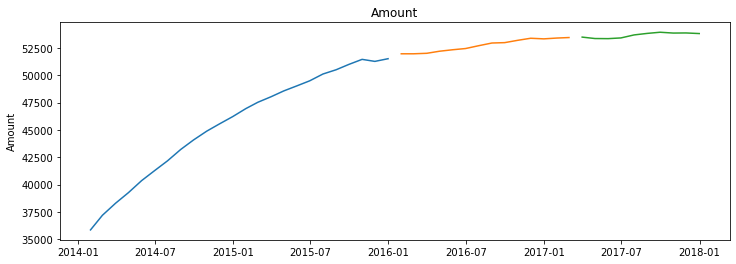

In [67]:
# plot split data

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show();


## Forecast

#### Evaluate Function

In [38]:
# function to compute rmse for evaluation 

def evaluate(target_var):
    '''
    This function computes rmse for evaluation
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_saas[target_var])), 0)
    return rmse

In [39]:
# function to eval and compares preformance by plotting train and test with predicted values

# plot and evaluate 
def plot_and_eval(target_var):
    
    '''
    This function uses evaluate to eval and compare preformance 
    by plotting train and test with predicted values
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [40]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    This function appends evaluation metrics to eval_df
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [41]:
eval_df

,model_type,target_var,rmse


#### Make Predictions Function

In [77]:
def make_predictions():
    '''
    This function 
    adds values to the dataframe 
    yhat_saas to make predictions
    '''
    yhat_saas = pd.DataFrame({'Amount':[amounts]
                         }, index = validate.index)
    return yhat_saas

### Last Observed Method

last observed value: future values are predicted to be the last observed value

#### Make Prediction

In [61]:
# last ovserved value
amounts = train['Amount'][-1:][0]

# add values to new dataframe yhat_saas to make predictions
yhat_saas = pd.DataFrame({'Amount':[amounts]}, index = validate.index)

yhat_saas.head(2)

,Amount
ds,
2016-01-31,51505.0
2016-02-29,51505.0


every predicted val is the same

#### Plot Actual vs. Predicted Values

Amount -- RMSE: 1343


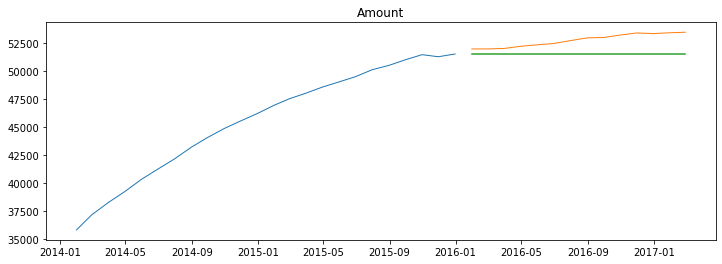

In [66]:
# plot actual and predicted values
for col in train.columns:
    plot_and_eval(col);


####  Evaluate 

In [54]:
# eval using RMSE 
# add metrics to eval_df

In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [53]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


### Simple Average Method

simple average: simple average of historic values to predict future values

#### Make Predictions

In [72]:
# adds simple avg to a var
amounts = round(train['Amount'].mean(), 2)

def make_predictions():
    '''
    This function 
    adds values to the dataframe 
    yhat_saas to make predictions
    '''
    yhat_saas = pd.DataFrame({'Amount':[amounts]
                         }, index = validate.index)
    return yhat_saas

yhat_saas.head(2)

,Amount
ds,
2016-01-31,51505.0
2016-02-29,51505.0


#### Plot Actual vs. Predicted Values



Amount -- RMSE: 1343


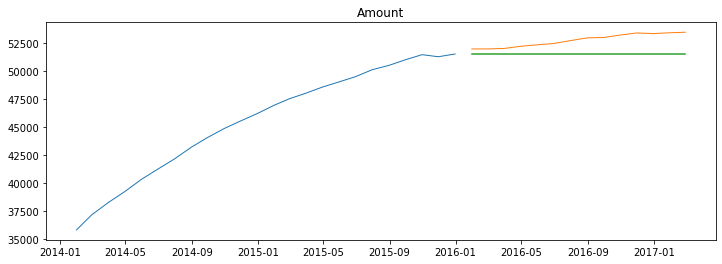

In [65]:
# plot actual and predicted values
for col in train.columns:
    plot_and_eval(col);

#### Evaluate 

In [68]:
# eval using RMSE 
# add metrics to eval_df

for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)


In [69]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,1343.0


### Moving Average Method

using 30-day moving average to forcast (avg of last 3 days)

#### Make Predictions

In [83]:
# avg of last 3 days 

period = 3

amounts = round(train['Amount'].rolling(period).mean().iloc[-1], 0)

yhat_saas = make_predictions()
yhat_saas.head(2)

,Amount
ds,
2016-01-31,51403.0
2016-02-29,51403.0


#### Plot Actual vs. Predicted Values



Amount -- RMSE: 1436


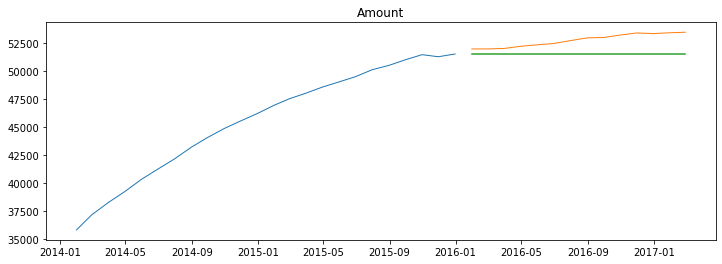

In [84]:
# plot actual and predicted values
for col in train.columns:
    plot_and_eval(col)


#### Evaluate 

In [86]:
# eval using RMSE 
# add metrics to eval_df

for col in train.columns:
    eval_df = append_eval_df(model_type='3d moving average', 
                             target_var = col)

In [87]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,1343.0
2,3d moving average,Amount,1436.0


### Holt's Linear Trend Method


Holt's Linear Trend: exponential smoothing applied to avg and trend (slope)


##### Basic Holt's Linear Trend

#### Make Predictions

In [93]:
model = Holt(train['Amount'], exponential = False)
model = model.fit(smoothing_level = .1, 
                    smoothing_slope = .1, 
                    optimized = False)



yhat_amounts = model.predict(start = validate.index[0], 
                        end = validate.index[-1])
yhat_saas['Amount'] = round(yhat_amounts, 2)


#### Plot Actual vs. Predicted Values

Amount -- RMSE: 8103


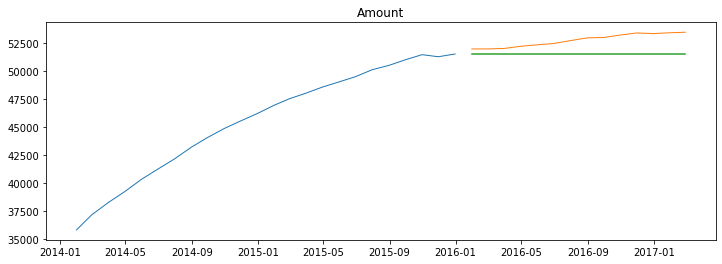

In [95]:
# plot actual and predicted values
for col in train.columns:
    plot_and_eval(col);

#### Evaluate 

In [99]:
# eval using RMSE 
# add metrics to eval_df

for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)


In [98]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,1343.0
2,3d moving average,Amount,1436.0
3,Holts,Amount,8103.0


### Previous Cycle Method

In [110]:
# resplit based on dates 

train = saas[:'2015']
validate = saas['2016']
test = saas['2017']

In [115]:
yhat_saas = train['2015'] + train.diff(365).mean()

In [116]:
pd.concat([yhat_saas.head(1), validate.head(1)])


,Amount
ds,
2015-01-31,NaN
2016-01-31,51955.0


In [117]:
yhat_saas.index = validate.index

len(yhat_saas)

12

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

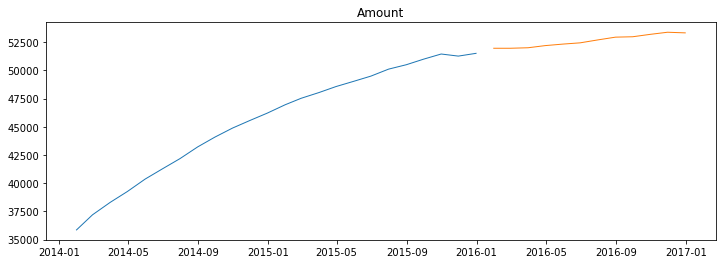

In [118]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)